# Loan Repayment Challenge

Note: Conclusion (Summarized Data Story) is at the end of this jupyter notebook.

#### Import necessary libraries

In [1]:
# conda install -c conda-forge statsmodels
# conda install -c conda-forge boruta_py
# conda install plotly
# conda install -c conda-forge imbalanced-learn
# pip install altair     
# conda install geopandas
# conda install altair-viewer
# conda install scikit-learn
# conda install squarify

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import geopandas as gpd
import IPython.display as display
import networkx as nx
import circlify

from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
from statsmodels.graphics.mosaicplot import mosaic


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator, FixedLocator

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go


import scipy.stats as stats
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import json
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', None)

sns.set()
%matplotlib inline

np.random.seed(0)

## Data Collection

In [3]:
df = pd.read_csv('cleaned_data.csv')
df = pd.DataFrame(df)

In [4]:
df.head(3)

LoanID                         HashedSSN PayFrequency    APR  \
0  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
1  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   

  ApplicationDate  PaidOffCount  IsFunded     LoanStatus  LoanAmount  \
0      2016-01-19             0      True  Paid Off Loan      3000.0   
1      2016-01-19             0      True  Paid Off Loan      3000.0   
2      2016-01-19             0      True  Paid Off Loan      3000.0   

   ScheduledPaymentAmount State   LeadType  LeadCost FirstPaymentStatus  \
0                 6395.19    CA  prescreen         0            Checked   
1                 6395.19    CA  prescreen         0            Checked   
2                 6395.19    CA  prescreen         0            Checked   

             ClarityFraudID  InstallmentIndex  IsCollection  Principal  \
0  569eb3a3e4b096699f685d64                 1         False     151.98   
1  569eb3a3e4b096699f685d64                 2         False      49.08   
2  569eb3a3e4b096699f685d64                 3         False      52.83   

     Fees  PaymentAmount PaymentStatus  CF.inquiry.30_days_ago  \
0  114.49         266.47       Checked                       3   
1  217.39         266.47       Checked                       3   
2  213.64         266.47       Checked                       3   

   CF.inquiry.24_hrs_ago  CF.inquiry.1_min_ago  CF.inquiry.1_hr_ago  \
0                      3                     3                    3   
1                      3                     3                    3   
2                      3                     3                    3   

   CF.inquiry.90_days_ago  CF.inquiry.7_days_ago  CF.inquiry.10_mins_ago  \
0                       3                      3                       3   
1                       3                      3                       3   
2                       3                      3                       3   

   CF.inquiry.15_days_ago  CF.inquiry.365_days_ago  \
0                       3                        4   
1                       3                        4   
2                       3                        4   

   CF.fs.inq_onf_addr_conflict  CF.fs.total_num_fraud_indicators  \
0                        False                                 0   
1                        False                                 0   
2                        False                                 0   

   CF.fs.phone_inconsistent_w_addr  CF.fs.inq_age_lt_ssn_date  \
0                            False                      False   
1                            False                      False   
2                            False                      False   

   CF.fs.onf_addr_cautious  CF.fs.inq_addr_non_residential  \
0                    False                           False   
1                    False                           False   
2                    False                           False   

   CF.fs.onf_addr_high_risk  CF.fs.ssn_frequent_for_another  \
0                     False                           False   
1                     False                           False   
2                     False                           False   

   CF.fs.cur_addr_rep_trade_90_days  CF.fs.in_ssn_invalid  \
0                             False                 False   
1                             False                 False   
2                             False                 False   

   CF.fs.in_ssn_date_unverified  CF.fs.inq_addr_cautious  \
0                         False                    False   
1                         False                    False   
2                         False                    False   

   CF.fs.inq_gt_3_in_last_30_days  CF.fs.onf_addr_non_residential  \
0                           False                           False   
1                           False                           False   
2                        

## Exploratory Data Analysis (EDA)

In [5]:
non_cf_columns = [col for col in df.columns if not col.startswith('CF.')]
cf_columns = [col for col in df.columns if col.startswith('CF.')]

loan_payment_df = df[non_cf_columns]

underwriting_df = df[cf_columns].copy() 
underwriting_df = underwriting_df.assign(FraudScore=df['FraudScore'].values)

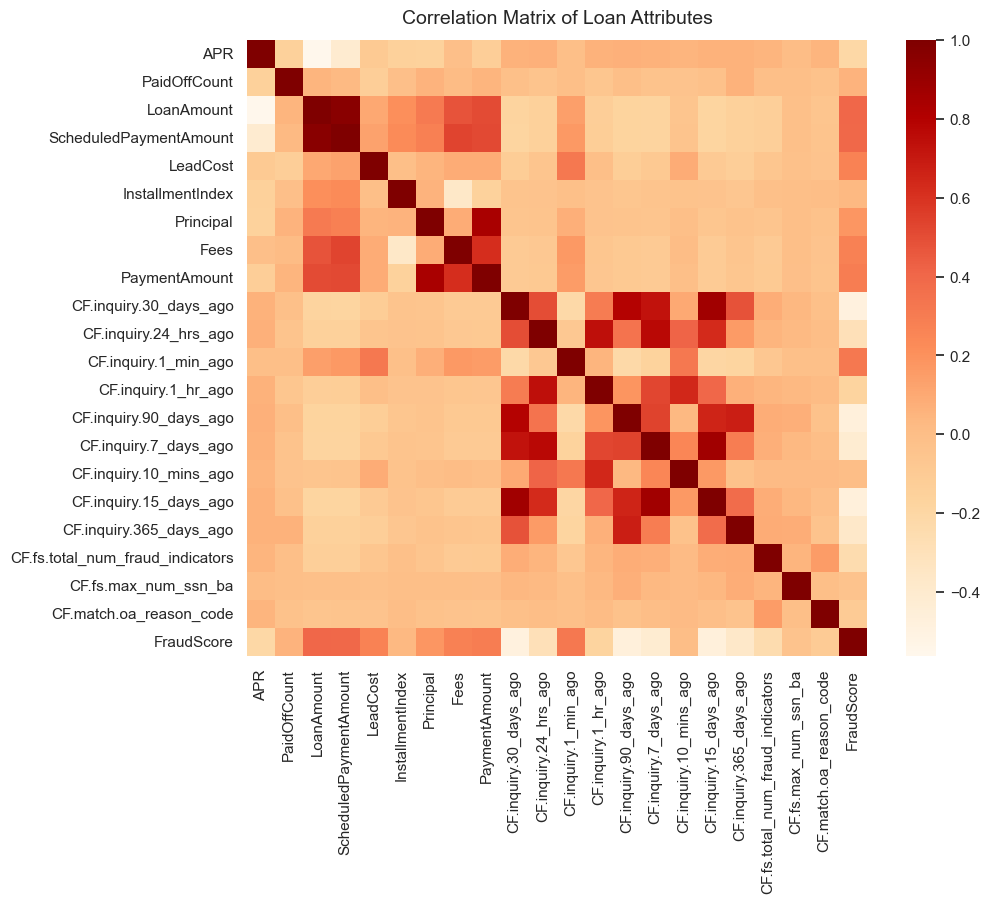

In [6]:
numeric_cols_loan = df.select_dtypes(include=[np.number])
correlation_matrix_loan = numeric_cols_loan.corr()

plt.figure(figsize=(10, 8))
heatmap_loan = sns.heatmap(correlation_matrix_loan, cmap='OrRd', annot_kws={"size": 10}, fmt='.2f')
heatmap_loan.set_title("Correlation Matrix of Loan Attributes", fontdict={'fontsize': 14}, pad=12)
plt.show()

## Loan Origination and Amount Distributed Patterns

#### What is the trend in loan origination over time?

In [7]:
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
loan_origination_trend = df.groupby(df['ApplicationDate'].dt.to_period('M')).size()
loan_origination_trend

ApplicationDate
2015-01       84
2015-02     1142
2015-03      797
2015-04     2073
2015-05     5217
2015-06     3973
2015-07     6623
2015-08    11941
2015-09     8230
2015-10    10967
2015-11    23387
2015-12    31085
2016-01    24651
2016-02    13545
2016-03    18914
2016-04    25404
2016-05    16520
2016-06    26472
2016-07    21877
2016-08    17732
2016-09    11942
2016-10     5703
2016-11    26266
2016-12    92692
2017-01    62972
Freq: M, dtype: int64

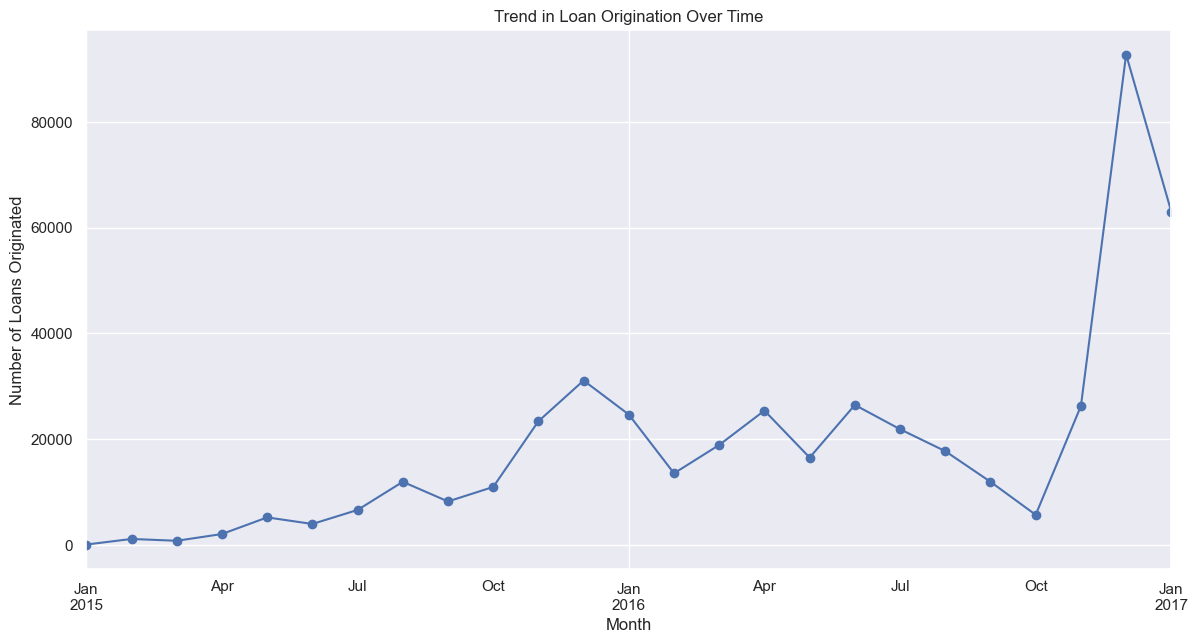

In [8]:
plt.figure(figsize=(14, 7))
loan_origination_trend.plot(kind='line', marker='o')
plt.title('Trend in Loan Origination Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Loans Originated')
plt.grid(True)
plt.show()

From January 2015 to early 2016, there is a gradual increase in the number of loans originated with slight fluctuations. Throughout 2016, there are notable fluctuations in loan origination numbers, with peaks and troughs observed at various points during the year. There is a noticeable peak in loan originations around late 2016, reaching the highest point on the graph. After the peak in late 2016, there is a sharp decline in the number of loans originated, which continues into early 2017.

#### What is the distribution of loan amounts? 

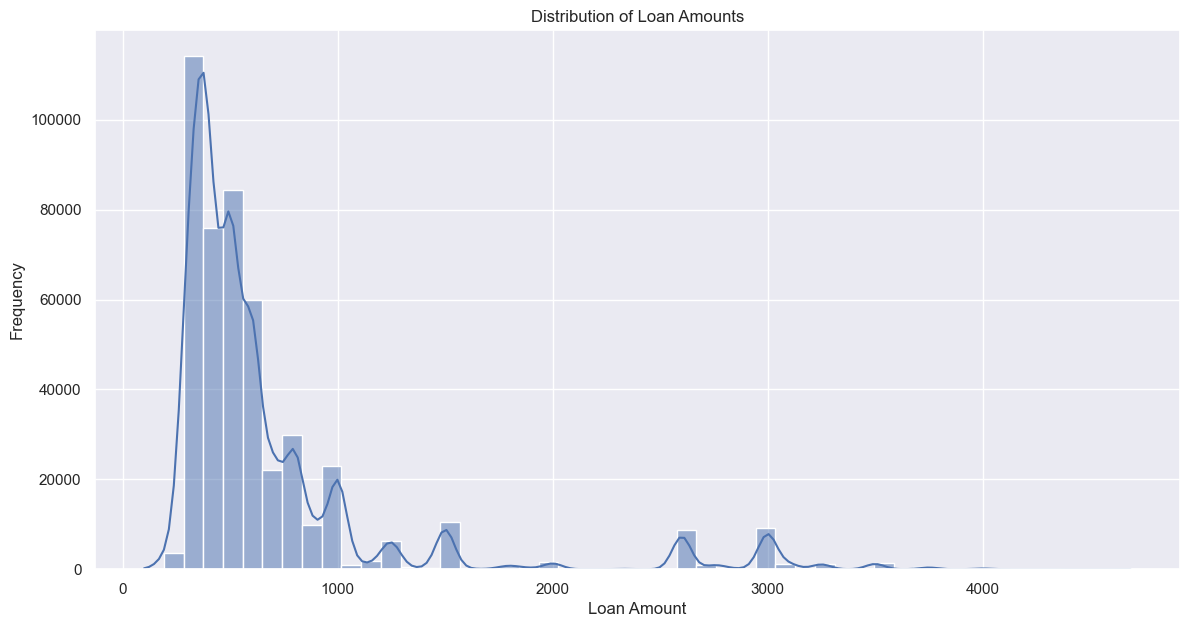

In [9]:
plt.figure(figsize=(14, 7))
sns.histplot(df['LoanAmount'], bins=50, kde=True)
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

The distribution of loan amounts is heavily right-skewed, with the majority of loans concentrated on the lower end of the scale. This means that most loan amounts are relatively small. The highest frequency for loan amounts distributed is between approximately 0 and 500, indicating that a large number of loans issued fall within this range. As the loan amount increases, the frequency of loans decreases sharply. There are several smaller peaks at higher loan amounts (around 1000, 2000, and 3000). The distribution has a long tail extending towards higher loan amounts (up to 4000). This long tail shows that while rare, there are some instances of significantly larger loans.

#### Which states has the highest and lowest number of loan applicants?

In [10]:
unique_loans = df.drop_duplicates(subset='LoanID')

state_loan = unique_loans.groupby('State').agg(
    TotalLoans=('LoanID', 'nunique'),
)
state_loan.reset_index(inplace=True)

In [69]:
fig = px.choropleth(
    state_loan,
    locations='State',
    locationmode='USA-states',
    color='TotalLoans',
    color_continuous_scale='OrRd',
    scope='usa',
    labels={'TotalLoans': 'Total Number of Loans'},
    title='Choropleth Map of Total Number of Loans by State',
    hover_data={'State': False, 'TotalLoans': False}
)

for i, row in state_loan.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='USA-states',
        locations=[row['State']],
        text=f"{row['State']}<br>{row['TotalLoans']}",
        mode='text',
        showlegend=False,
        textfont=dict(size=10, color="black"),
        hoverinfo='none'  
    ))


pio.renderers.default = 'notebook_connected'
pio.write_html(fig, './choropleth_map.html')

display.display(display.IFrame(src='./choropleth_map.html', width=800, height=600))

States in the Midwestern United States, especially Ohio (OH), Illinois (IL), Indiana (IN), Michigan (MI), and Wisconsin (WI), have the highest concentration of loan applicants. States like California (CA), Texas (TX) and Florida (FL) also showing notable demand. States with the lowest number of loan applicants include North Dakota (ND), Hawaii (HI), Rhode Island (RI) and Alaska (AK) have less than 50 loan applicants.

## Assessing Loan Performance

#### Loan Status Breakdown

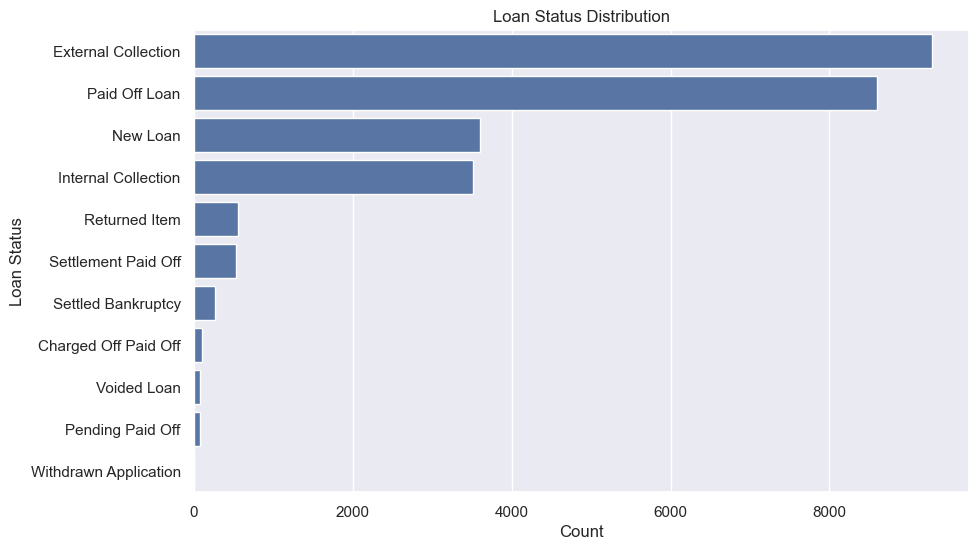

In [12]:
loan_status_counts = unique_loans['LoanStatus'].value_counts().sort_values(ascending=False)
sorted_loan_status = loan_status_counts.reset_index()
sorted_loan_status.columns = ['LoanStatus', 'Count']

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='LoanStatus', data=sorted_loan_status, order=sorted_loan_status['LoanStatus'])
plt.title('Loan Status Distribution')
plt.ylabel('Loan Status')
plt.xlabel('Count')
plt.show()

#### How does pay frequency affect loan performance and customer repayment behavior?

Do clients with more frequent pay schedules (e.g., bi-weekly) show better repayment performance compared to those with less frequent pay schedules (e.g., monthly)?

In [20]:
df['LoanStatus'].unique()

array(['Paid Off Loan', 'New Loan', 'External Collection',
       'Internal Collection', 'Returned Item', 'Charged Off Paid Off',
       'Settled Bankruptcy', 'Settlement Paid Off', 'Voided Loan',
       'Pending Paid Off', 'Withdrawn Application'], dtype=object)

In [66]:
unique_loans.head(3)

HashedSSN         LoanID  PaidOffCount  LoanAmount  \
0   464f5d9ae4fa09ece4048d949191865c  LL-I-06644937             0      3000.0   
25  bc9fa73468acf18cb968a3a6a3c4697c  LL-I-16519347             2      1250.0   
38  10cefd11d41612b032fd9cd2debe32dc  LL-I-11506719             0       800.0   

    FraudScore ApplicationDate  
0        879.0      2016-01-19  
25       835.0      2017-01-31  
38       624.0      2016-08-27

In [23]:
loan_payf_df = unique_loans.groupby(['PayFrequency', 'LoanStatus'])['LoanID'].nunique().reset_index(name='UniqueLoanCount')

total_loans_per_frequency = loan_payf_df.groupby('PayFrequency')['UniqueLoanCount'].sum().reset_index(name='TotalLoanCount')

loan_payf_df = loan_payf_df.merge(total_loans_per_frequency, on='PayFrequency')

loan_payf_df['Percentage'] = (loan_payf_df['UniqueLoanCount'] / loan_payf_df['TotalLoanCount']) * 100

#filter out loans that is withdrawn and voided
loan_payf_df = loan_payf_df[~loan_payf_df['LoanStatus'].isin(['Withdrawn Application', 'Voided Loan'])]

In [24]:
sorted_loan_payf_df = loan_payf_df.sort_values(by='Percentage', ascending=False)

In [62]:
sorted_loan_payf_df.head(3)

PayFrequency           LoanStatus  UniqueLoanCount  TotalLoanCount  \
15            I        Paid Off Loan              282             415   
40            W  External Collection             2994            7746   
1             B  External Collection             5370           15357   

    Percentage  
15   67.951807  
40   38.652208  
1    34.967767

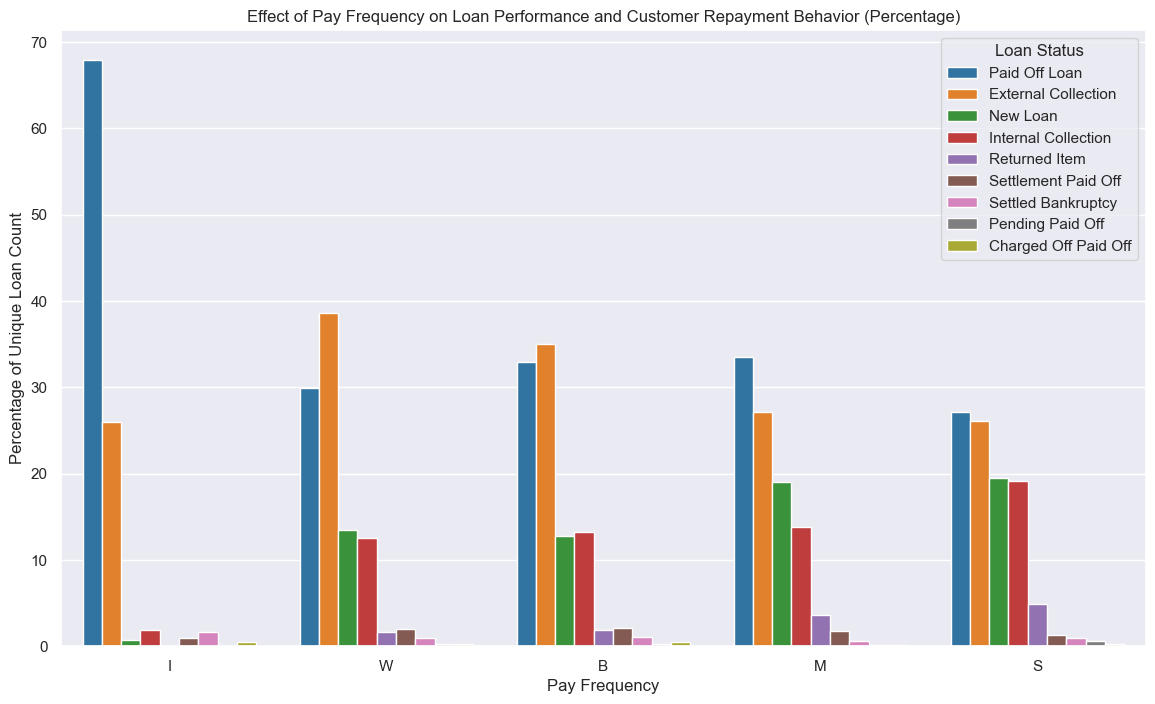

In [26]:
plt.figure(figsize=(14, 8))
sns.barplot(data=sorted_loan_payf_df, x='PayFrequency', y='Percentage', dodge=True, hue='LoanStatus', palette='tab10')
plt.title('Effect of Pay Frequency on Loan Performance and Customer Repayment Behavior (Percentage)')
plt.xlabel('Pay Frequency')
plt.ylabel('Percentage of Unique Loan Count')
plt.legend(title='Loan Status')
plt.show()

Irregular payment frequencies have the highest success rate in terms of loan repayment. Weekly, biweekly, monthly, and semi-monthly frequencies all show a mix of paid-off loans and loans in external collection, with varying degrees of success. External collection is a significant category for all pay frequencies except irregular, highlighting repayment challenges across different payment schedules. Internal collections and new loans are consistently present, reflecting ongoing repayment management efforts and new loan issuances across different frequencies.

#### How does the initial checking process (Checked vs. Not Checked) influence the distribution of loan outcomes across various loan statuses?

In [29]:
categorized_df = df.copy()
not_checked_values = ['Rejected', 'None', 'Skipped', 'No Payments', 'Cancelled', 'Pending']
categorized_df['CategorizedPaymentStatus'] = categorized_df['FirstPaymentStatus'].replace(not_checked_values, 'Not Checked')

grouped_df = categorized_df.groupby(['CategorizedPaymentStatus', 'LoanStatus'])['LoanID'].nunique().reset_index()
grouped_df.rename(columns={'LoanID': 'UniqueLoanStatusCount'}, inplace=True)
grouped_df

CategorizedPaymentStatus            LoanStatus  UniqueLoanStatusCount
0                   Checked  Charged Off Paid Off                     68
1                   Checked   External Collection                   6570
2                   Checked   Internal Collection                   2694
3                   Checked              New Loan                   3565
4                   Checked         Paid Off Loan                   8308
5                   Checked      Pending Paid Off                     67
6                   Checked         Returned Item                    486
7                   Checked    Settled Bankruptcy                    218
8                   Checked   Settlement Paid Off                    456
9               Not Checked  Charged Off Paid Off                     34
10              Not Checked   External Collection                   2715
11              Not Checked   Internal Collection                    820
12              Not Checked              New Loan                     35
13              Not Checked         Paid Off Loan                    284
14              Not Checked      Pending Paid Off                      7
15              Not Checked         Returned Item                     66
16              Not Checked    Settled Bankruptcy                     45
17              Not Checked   Settlement Paid Off                     76

In [30]:
pivot_df = grouped_df.pivot(index='LoanStatus', columns='CategorizedPaymentStatus', values='UniqueLoanStatusCount').fillna(0)
pivot_df

CategorizedPaymentStatus  Checked  Not Checked
LoanStatus                                    
Charged Off Paid Off           68           34
External Collection          6570         2715
Internal Collection          2694          820
New Loan                     3565           35
Paid Off Loan                8308          284
Pending Paid Off               67            7
Returned Item                 486           66
Settled Bankruptcy            218           45
Settlement Paid Off           456           76

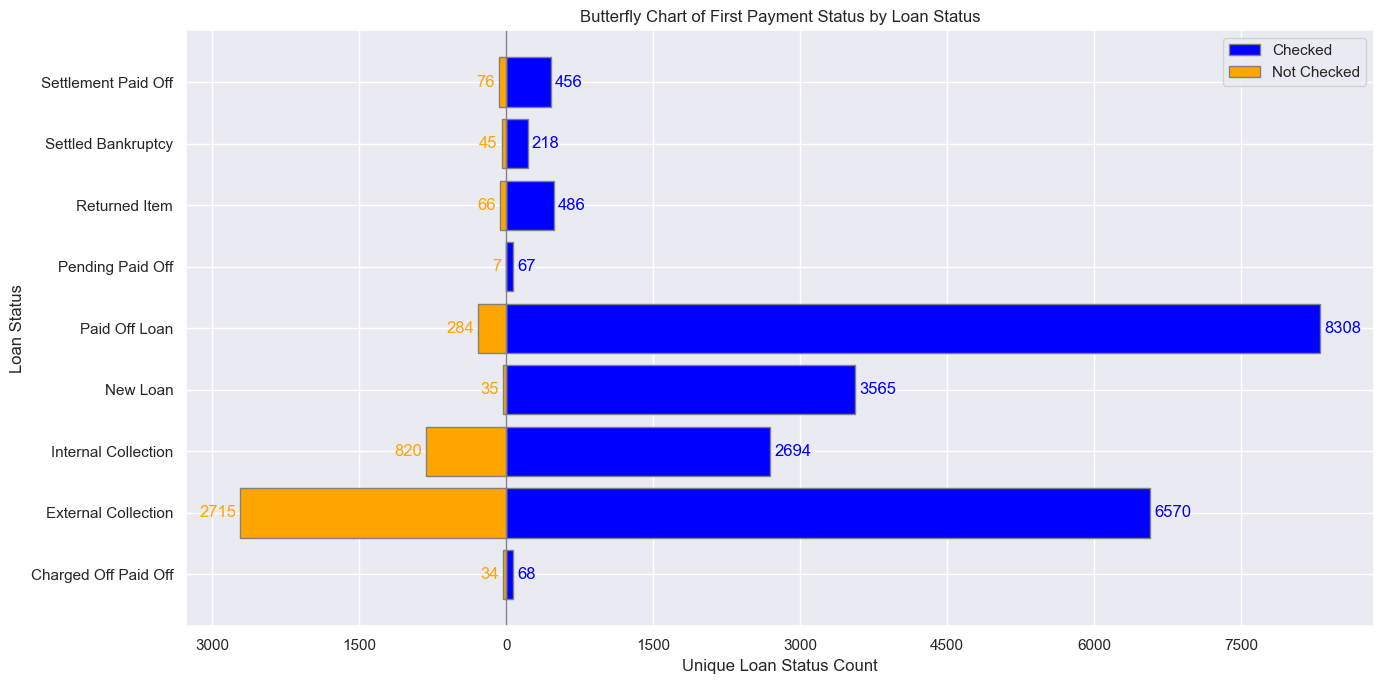

In [31]:
checked = pivot_df['Checked']
not_checked = pivot_df['Not Checked']

fig, ax = plt.subplots(figsize=(14, 7))

bars_checked = ax.barh(checked.index, checked, color='blue', edgecolor='grey', label='Checked')

bars_not_checked = ax.barh(not_checked.index, -not_checked, color='orange', edgecolor='grey', label='Not Checked')

ax.axvline(0, color='grey', linewidth=1)

for bar in bars_checked:
    ax.annotate(f'{int(bar.get_width())}', xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                xytext=(3, 0), textcoords='offset points', ha='left', va='center', color='blue')

for bar in bars_not_checked:
    ax.annotate(f'{int(-bar.get_width())}', xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                xytext=(-3, 0), textcoords='offset points', ha='right', va='center', color='orange')

ax.set_xlabel('Unique Loan Status Count')
ax.set_ylabel('Loan Status')
ax.set_title('Butterfly Chart of First Payment Status by Loan Status')
ax.legend(loc='upper right')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels([abs(int(x)) for x in ticks])

plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

Clients whose loans are marked as "checked" in their first payment status demonstrate a higher likelihood of successful loan repayment. These loans are more likely to advance to the new loan status, indicating better initial eligibility and processing. While Returned Item and Collection (Internal and External) occurrences are also more frequent in the "checked" category, their distribution is less skewed compared to Paid Off Loan and New Loan statuses. Thus, the first payment status significantly influences the distribution of loan outcomes, enhancing overall loan performance and risk management.

## Customer Segmentation and Behavior

### Clustering Technique


##### How do the risk levels (Very High Risk, High Risk, Moderate Risk, Low Risk) correlate with the average loan amount and the number of paid-off loans among different customer segments?

In [32]:
client_loan_counts = df.groupby('HashedSSN')['LoanID'].nunique().reset_index()
client_loan_counts.rename(columns={'LoanID': 'TotalLoans'}, inplace=True)
client_loan_counts.head(10)

HashedSSN  TotalLoans
0  00006b47f484731c95b4c11a42f9c2e3           1
1  00069c6c4fa5fa1b94b845ffde8e081b           1
2  00094b88d7a7caea540dd3c77fe1ff9c           1
3  000c0aa9b221e0ca8bb76dfd55d3847c           1
4  000e7188ab65dde1f6a8a576f28d8d24           1
5  000edb0725f9806280727fbff1099655           1
6  001589271175754efc9643fd2d4b654b           1
7  00166d34c1276616154d830a9ef2f620           1
8  0019a85f11c8d85805ea90b4deb461a4           1
9  0019b5c1cef8a2ae5c729f31f8d4b04d           1

In [63]:
unique_loans = df[['HashedSSN', 'LoanID', 'PaidOffCount','LoanAmount','FraudScore','ApplicationDate']].drop_duplicates()
client_avg_loan_amount = unique_loans.groupby('HashedSSN')[['LoanAmount','FraudScore']].mean().reset_index()
client_avg_loan_amount.rename(columns={'LoanAmount': 'AvgLoanAmount', 'FraudScore': 'AvgFraudScore'}, inplace=True)
client_avg_loan_amount.head(3)

HashedSSN  AvgLoanAmount  AvgFraudScore
0  00006b47f484731c95b4c11a42f9c2e3          500.0          736.0
1  00069c6c4fa5fa1b94b845ffde8e081b          300.0          545.0
2  00094b88d7a7caea540dd3c77fe1ff9c          600.0          710.0

In [64]:
latest_paid_off_count = unique_loans.loc[unique_loans.groupby('HashedSSN')['ApplicationDate'].idxmax()][['HashedSSN', 'PaidOffCount']]

client_avg_loan_amount = pd.merge(client_avg_loan_amount, latest_paid_off_count, on='HashedSSN')
client_avg_loan_amount.head(3)

HashedSSN  AvgLoanAmount  AvgFraudScore  \
0  00006b47f484731c95b4c11a42f9c2e3          500.0          736.0   
1  00069c6c4fa5fa1b94b845ffde8e081b          300.0          545.0   
2  00094b88d7a7caea540dd3c77fe1ff9c          600.0          710.0   

   PaidOffCount  
0             0  
1             0  
2             0

In [36]:
df_clustering = client_avg_loan_amount[['AvgLoanAmount', 'PaidOffCount', 'AvgFraudScore']]

scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

kmeans = KMeans(n_clusters=4, random_state=42)
df_clustering['Cluster'] = kmeans.fit_predict(df_clustering_scaled)

cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)


risk_labels = ['Very High Risk', 'High Risk', 'Moderate Risk', 'Low Risk']
sorted_indices = np.argsort(cluster_centers[:, 2])[::-1]
cluster_risk_mapping = {sorted_indices[i]: risk_labels[i] for i in range(4)}

df_clustering['RiskLevel'] = df_clustering['Cluster'].map(cluster_risk_mapping)

df_clustering['Cluster'] = df_clustering['Cluster'].astype(str)

alt.data_transformers.disable_max_rows()

selection = alt.selection_multi(fields=['RiskLevel'], bind='legend')
scales = alt.selection_interval(bind='scales')

dom = ['Very High Risk', 'High Risk', 'Moderate Risk', 'Low Risk']
rng = ['#f04848','#f09f48', '#a2e36d', '#e3f36d ']

box_plot = alt.Chart(df_clustering).mark_boxplot(extent='min-max').encode(
    x=alt.X('PaidOffCount:O', title='Paid Off Count'),
    y=alt.Y('AvgLoanAmount:Q', title='Average Loan Amount'),
    color=alt.Color('RiskLevel:N', scale=alt.Scale(domain=dom, range=rng)),
    tooltip=['RiskLevel', 'AvgFraudScore']
).properties(
    width=1000,
    height=400
)

box_plot.display()

Cluster Centers:
 [[ 3.46536295 -0.21541793  1.16326772]
 [-0.06893668 -0.3089804   0.67014861]
 [ 0.00595313  2.30000833  0.20175742]
 [-0.39625162 -0.28456563 -0.95695441]]


alt.Chart(...)

In [37]:
numeric_cols = df_clustering.select_dtypes(include=['float64', 'int64']).columns
cluster_analysis = df_clustering.groupby('Cluster')[numeric_cols].mean().reset_index
cluster_analysis

<bound method DataFrame.reset_index of          AvgLoanAmount  PaidOffCount  AvgFraudScore
Cluster                                            
0          2320.385401      0.047655     831.465582
1           598.014304      0.000000     767.522571
2           634.083717      1.326736     706.550516
3           438.407335      0.012294     556.609159>

The graph reveals four distinct customer segments based on average loan amounts and paid-off counts, colored by risk levels. Very High Risk customers take the largest loans and have the fewest paid-off counts, indicating they are at the highest risk of default. High Risk customers also have low paid-off counts but with slightly lower average loan amounts. Moderate Risk customers take smaller loans and have the highest paid-off counts, suggesting they are the least risky and most reliable in terms of loan repayment. Lastly, Low Risk customers show a balanced profile with moderate loan amounts and a moderate number of paid-off loans. This segmentation highlights the correlation between higher loan amounts, lower paid-off counts, and increased risk levels.

#### What are the common characteristics of clients who have high FraudScore (categorized as high risk level)?

In [38]:
cluster_0_customers = df_clustering[df_clustering['Cluster'] == '0']

In [39]:
cluster_0_details = client_avg_loan_amount[client_avg_loan_amount.index.isin(cluster_0_customers.index)]
cluster_0_details = cluster_0_details.join(df.set_index('HashedSSN'), on='HashedSSN', rsuffix='_original')

In [40]:
df_clustering

AvgLoanAmount  PaidOffCount  AvgFraudScore Cluster      RiskLevel
0              500.0             0          736.0       1      High Risk
1              300.0             0          545.0       3       Low Risk
2              600.0             0          710.0       1      High Risk
3              600.0             1          872.0       2  Moderate Risk
4              600.0             0          782.0       1      High Risk
...              ...           ...            ...     ...            ...
24623          350.0             0          851.0       1      High Risk
24624          400.0             0          401.0       3       Low Risk
24625          350.0             0          684.0       1      High Risk
24626          400.0             0          372.0       3       Low Risk
24627          300.0             0          646.0       3       Low Risk

[24628 rows x 5 columns]

In [41]:
cf_columns = [col for col in df.columns if col.startswith('CF')]

df_clustering['HashedSSN'] = client_avg_loan_amount['HashedSSN']

hashed_ssns = df_clustering['HashedSSN'].unique()

all_unique = True
for hashed_ssn in hashed_ssns:
    filtered_df = df[df['HashedSSN'] == hashed_ssn]
    for col in cf_columns:
        unique_values = filtered_df[col].unique()
        if len(unique_values) != 1:
            all_unique = False
            print(f"HashedSSN: {hashed_ssn} has multiple unique values for {col}: {unique_values}")
            break
    if not all_unique:
        break

if all_unique:
    print("All HashedSSN values in df_clustering have only one unique value for all CF columns.")
else:
    print("Some HashedSSN values in df_clustering have multiple unique values for CF columns.")

HashedSSN: 011b10213306cc878fff2ffd0fbfc2bb has multiple unique values for CF.inquiry.30_days_ago: [6 2]
Some HashedSSN values in df_clustering have multiple unique values for CF columns.


In [42]:
filter = df[(df['HashedSSN'] == '011b10213306cc878fff2ffd0fbfc2bb')].head(10)
filter[(filter['CF.inquiry.30_days_ago'] >= 0)].head(300)
filter[['CF.inquiry.30_days_ago']]

CF.inquiry.30_days_ago
45704                       6
45705                       6
45706                       6
45707                       6
45708                       6
45709                       6
77118                       2
77119                       2
77120                       2
77121                       2

In [43]:
filtered_df = df[['HashedSSN'] + ['FraudScore'] + [col for col in df.columns if col.startswith('CF.')]].drop_duplicates()
cf_df = filtered_df.merge(df_clustering, on='HashedSSN')
high_cf_df = cf_df[(cf_df['RiskLevel'] == 'High Risk')].head(10)

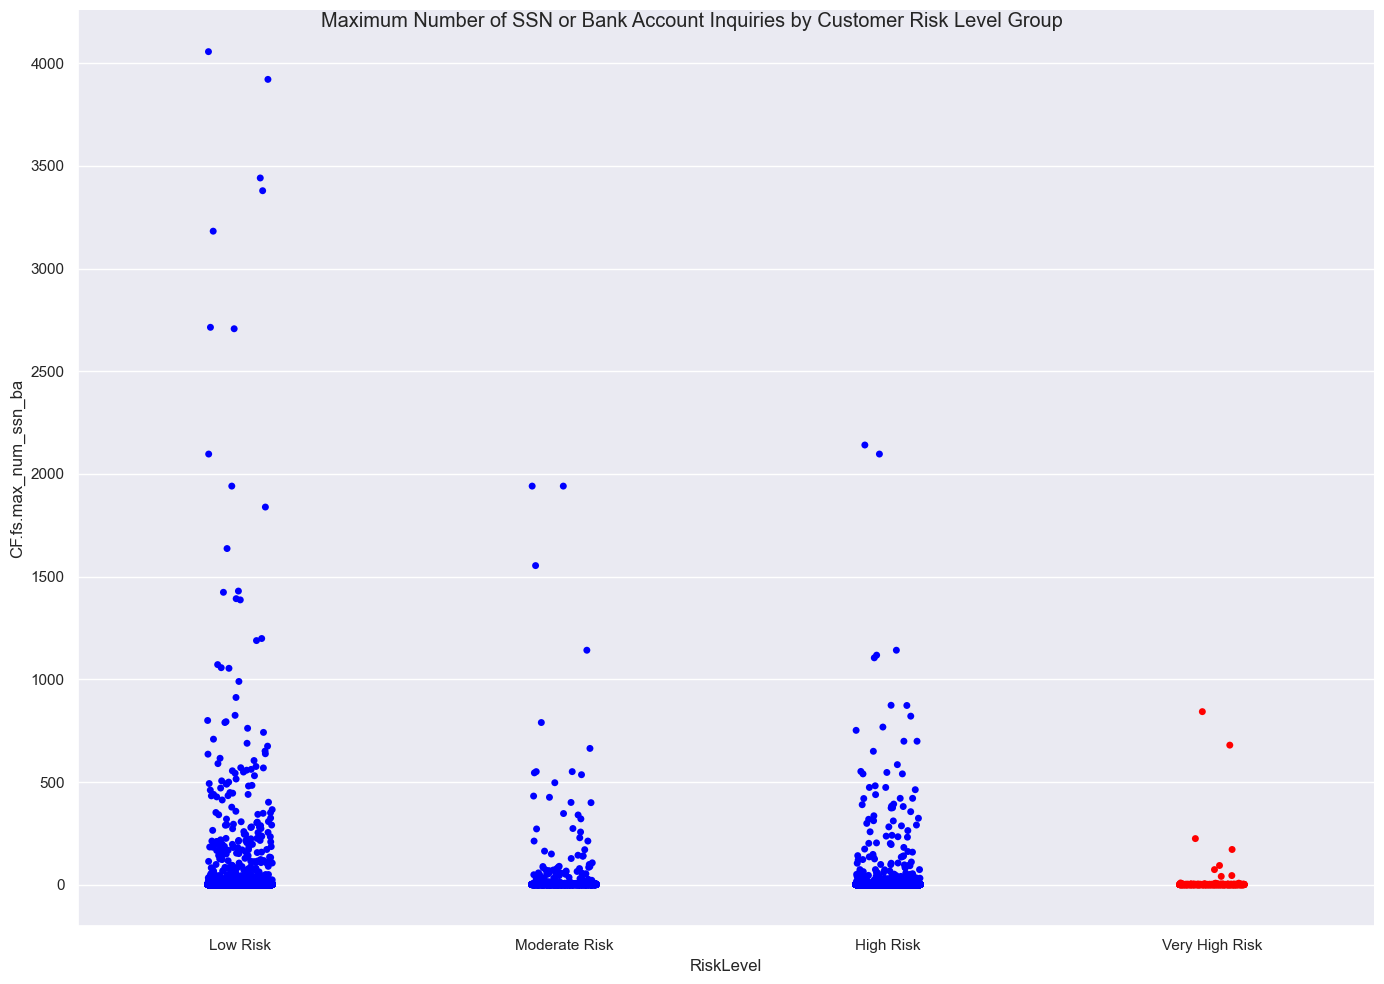

In [45]:
risk_order = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
palette = {'Low Risk': 'blue', 'Moderate Risk': 'blue', 'High Risk': 'blue', 'Very High Risk': 'red'}

g = sns.catplot(x='RiskLevel', y='CF.fs.max_num_ssn_ba', data=cf_df, kind='strip', palette=palette, order=risk_order, height=10, aspect=1.4)
g.fig.suptitle('Maximum Number of SSN or Bank Account Inquiries by Customer Risk Level Group')
plt.show()

plt.show()

All data points in very high risk group are tightly grouped at the lower end of the inquiry scale, predominantly ranging from 0 to 300. The spread is narrower compared to other risk groups, indicating less variability number of inquiries for this group. The Low Risk, Moderate Risk, and High Risk groups show a wider spread in the number of inquiries. These groups have a significant number of outliers, with counts extending up to 4000 inquiries in the Low Risk group and 2500 in the Moderate Risk group. The central tendency for the Very High Risk group is lower as there are fewer extreme values compared to the other risk groups, suggesting a more consistent behavior among very high-risk customers regarding SSN or bank account inquiries.

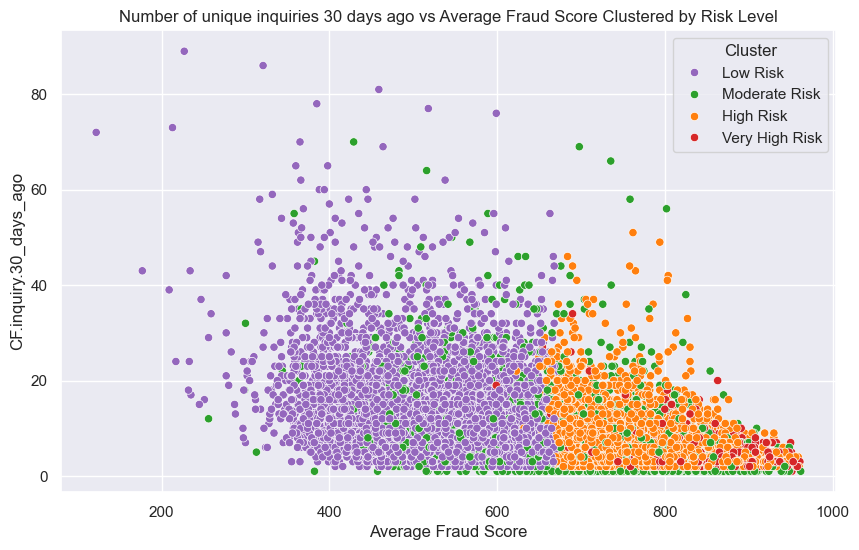

In [46]:
plt.figure(figsize=(10, 6))

risk_group = {
    'Very High Risk': 'tab:red',  
    'High Risk': 'tab:orange',     
    'Moderate Risk': 'tab:green',  
    'Low Risk': 'tab:purple'   
}

sns.scatterplot(x='AvgFraudScore', y='CF.inquiry.30_days_ago', hue='RiskLevel', \
                hue_order=risk_order, palette=risk_group, data=cf_df)

plt.title('Number of unique inquiries 30 days ago vs Average Fraud Score Clustered by Risk Level')
plt.xlabel('Average Fraud Score')
plt.ylabel('CF.inquiry.30_days_ago')
plt.legend(title='Cluster')

As the average fraud score increases, there is a corresponding slightly decrement in the number of inquiries made 30 days ago. This trend is visually represented by a concentration of very high-risk and high-risk clients at the higher end of the fraud score axis, yet these groups generally report fewer inquiries in the past 30 days. In contrast, clients with moderate risk and low risk show more variability in both fraud scores and inquiry activity, indicating a broader range of behaviors and risk levels.

In [48]:
value_counts = cf_df['CF.match.phone_match_result'].value_counts()

In [49]:
mismatch_count = (cf_df['CF.match.phone_match_result'] == 'mismatch').sum()

In [50]:
value_counts = cf_df['CF.match.phone_match_result'].value_counts()

total_counts = cf_df['CF.match.phone_match_result'].count()

proportions = value_counts / total_counts

proportions

CF.match.phone_match_result
unavailable    0.954807
match          0.023369
invalid        0.013269
partial        0.005070
mismatch       0.003486
Name: count, dtype: float64

In [51]:
def calculate_proportions(df, column_name):
    value_counts = df[column_name].value_counts()
    total_counts = df[column_name].count()
    proportions = value_counts / total_counts
    return proportions

In [52]:
cluster_groups = cf_df.groupby('RiskLevel')
proportion_results = {}

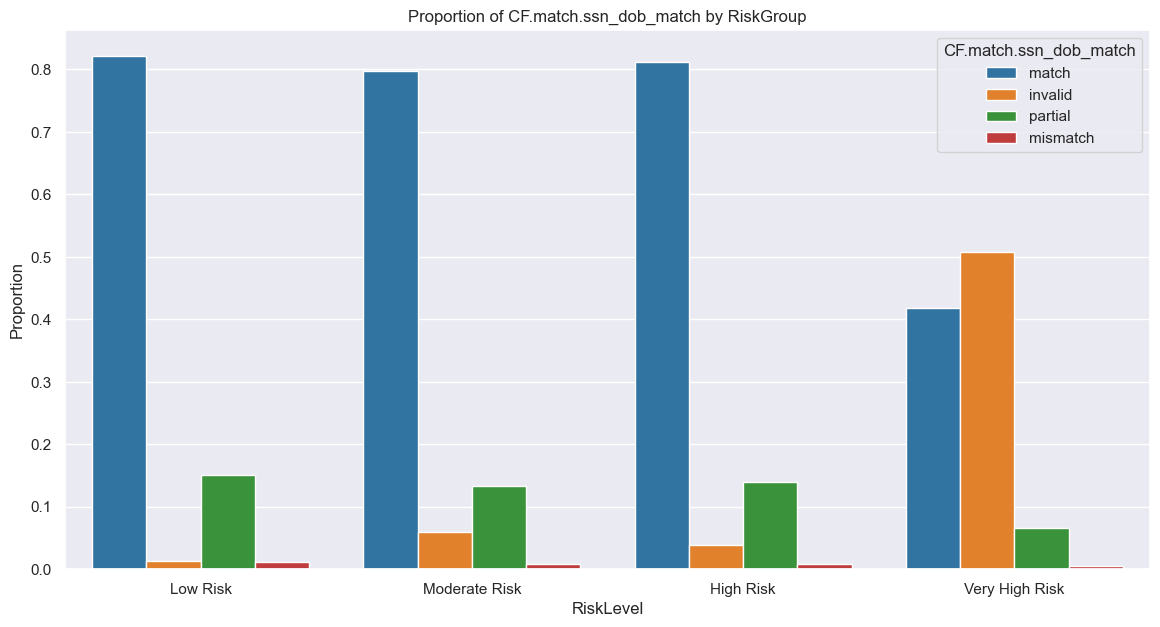

In [53]:
for group, data in cluster_groups:
    proportions = calculate_proportions(data, 'CF.match.ssn_dob_match')
    proportion_results[group] = proportions
    
ssndob_match_proportions_df = pd.DataFrame(proportion_results).transpose()

ssndob_match_proportions = ssndob_match_proportions_df.reset_index().melt(id_vars='index', value_name='Proportion')

ssndob_match_proportions.columns = ['RiskLevel', 'CF.match.ssn_dob_match', 'Proportion']

#filter out unavailable records
ssndob_match_proportions = ssndob_match_proportions[~ssndob_match_proportions['CF.match.ssn_dob_match'].isin(['unavailable'])]

sorted_ssndob_match_proportions = ssndob_match_proportions.sort_values(by='Proportion', ascending=False)

plt.figure(figsize=(14, 7))

sns.barplot(x='RiskLevel', y='Proportion', hue='CF.match.ssn_dob_match', data=sorted_ssndob_match_proportions, \
            palette='tab10', order=risk_order)

plt.title('Proportion of CF.match.ssn_dob_match by RiskGroup')

plt.show()

Low-risk clients shows the highest proportion of full matches, nearly reaching the top of the chart, has moderate occurrences of partial matches, and very minimal amount of invalid or mismatches entries. This suggests a strong correlation between accurate personal information submission and a lower risk assessment. Similar to low risk group, moderate risk group and high risk group have a slightly decreased presence of accurate matches and alightly increased in invalid entries. Notably, very high risk group highlights a significant increase in invalid matches, which are substantially higher than in other risk groups. Besides, its accurate matches has dropped significantly. This indicates clients who have a higher fraud score are more likely associated with incorrect SSN and DOB details.

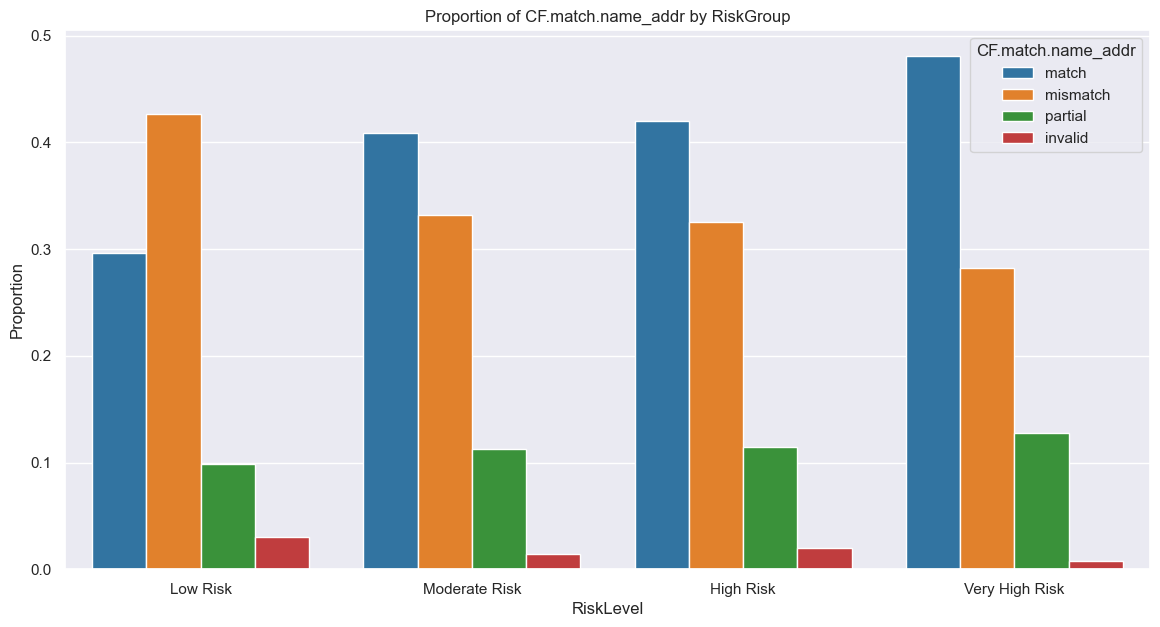

In [54]:
for group, data in cluster_groups:
    proportions = calculate_proportions(data, 'CF.match.name_addr')
    proportion_results[group] = proportions

nameaddr_proportions_df = pd.DataFrame(proportion_results).transpose()

nameaddr_proportions = nameaddr_proportions_df.reset_index().melt(id_vars='index', value_name='Proportion')

nameaddr_proportions.columns = ['RiskLevel', 'CF.match.name_addr', 'Proportion']

#filter out unavailable records
nameaddr_proportions = nameaddr_proportions[~nameaddr_proportions['CF.match.name_addr'].isin(['unavailable'])]

sorted_nameaddr_proportions = nameaddr_proportions.sort_values(by='Proportion', ascending=False)

plt.figure(figsize=(14, 7))

sns.barplot(x='RiskLevel', y='Proportion', hue='CF.match.name_addr', data=sorted_nameaddr_proportions, \
            palette='tab10', order=risk_order)

plt.title('Proportion of CF.match.name_addr by RiskGroup')

plt.show()

A surprisingly high proportion of full matches in the Very High Risk category suggests accurate name and address details even among the highest risk individuals. Mismatches are fairly consistent across Low, Moderate, and High Risk groups and notably lower in the Very High Risk group, suggesting that mismatches alone do not strongly correlate with the highest risk determination. Across all risk categories, partial matches has nearly 0.1 proportion, which suggest minor discrepancies in name or address details is very common. 

## Financial Insight

#### Which LeadType yields the highest revenue considering LeadCost and PaymentAmount?

In [55]:
filter = df[df['PaymentStatus'] == 'Checked']
filter['LeadType'].unique()

array(['prescreen', 'organic', 'bvMandatory', 'lead', 'california',
       'rc_returning', 'lionpay', 'repeat'], dtype=object)

In [56]:
filtered_df = df[df['PaymentStatus'] == 'Checked']

filtered_df['Revenue'] = filtered_df['PaymentAmount'] - filtered_df['LeadCost']

leadtype_revenue = filtered_df.groupby('LeadType').agg(
    total_revenue=('Revenue', 'sum'),
    avg_revenue=('Revenue', 'mean')
).reset_index()

highest_revenue_leadtype = leadtype_revenue.loc[leadtype_revenue['total_revenue'].idxmax()]

leadtype_revenue.sort_values("avg_revenue", ascending=False, inplace=True)
leadtype_revenue

LeadType  total_revenue  avg_revenue
5     prescreen     2260224.92   236.202834
6  rc_returning       93001.06   163.446503
4       organic     3915409.03   122.778584
1    california       78944.21   120.158615
2          lead     3920123.93    98.005548
3       lionpay        2030.47    84.602917
0   bvMandatory     6841338.55    81.480397
7        repeat        1957.90    75.303846

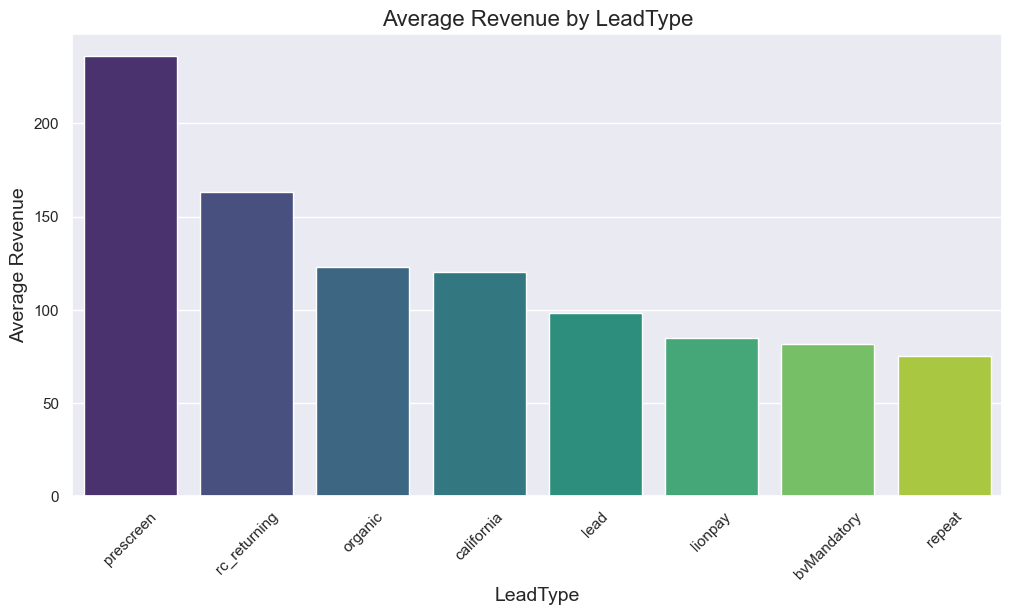

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(x='LeadType', y='avg_revenue', data=leadtype_revenue, palette='viridis')
plt.title('Average Revenue by LeadType', fontsize=16)
plt.xlabel('LeadType', fontsize=14)
plt.ylabel('Average Revenue', fontsize=14)
plt.xticks(rotation=45)
plt.show()

The LeadType that yields the highest revenue is prescreen with a total average revenue of $236.2, followed by rc_returning and organic channels. California-specific campaigns also perform well, while traditional lead, lionpay, bwMandatory, and repeat lead types yield lower average revenues.

## Conclusion

##### Loan Origination and Amount Distributed Patterns

From January 2015 to early 2016, there was a steady increase in loan originations , with notable fluctuations throughout 2016 and a peak in late 2016. A post-peak occured in late 2016, followed by a sharp decline continued into early 2017. The distribution of loan amounts shows a clear skew towards smaller loans, with the majority of borrowers taking out loans under $500. There are noticeable peaks at higher loan amounts, indicating standardized loan offerings. The regional loan demand can be divided into 3 groups. Midwest dominance include states like Ohio, Illinois, Indiana, Michigan, and Wisconsin. High demand states include California, Texas, and Florida.  Meanwhile, low demand states are North Dakota, Hawaii, Rhode Island, and Alaska.

##### Assessing Loan Performance

Loans with a successful first payment are more likely to be paid off and progress to new loan statuses. The status of the first payment helps identify and manage risks early, improving overall loan performance. Irregular payment frequencies have the highest success rate in terms of loan repayment. Weekly, biweekly, monthly, and semi-monthly frequencies all show a mix of paid-off loans and loans in external collection, with varying degrees of success. External collection is a significant category for all pay frequencies, except for irregular frequencies. This highlights the challenges exist across different payment schedules. Internal collections and new loans are consistently present, reflecting ongoing repayment management efforts and new loan issuances across different frequencies. This analysis suggests that repayment success varies widely across different pay frequencies, with irregular payments performing the best in terms of loan repayment, while external collections remain a common issue for most other payment schedules.

##### Customer Segmentation

The analysis reveals four distinct customer segments based on average loan amounts, average fraud score and latest paid-off counts. Very High Risk clients take the largest loans, fewest paid-off counts, and have the highest average fraud score, indicating they are at the highest risk of default. High risk clients have lower paid-off counts, slightly lower loan amounts and slightly lower fraud score than very high risk group. Moderate Risk clients have moderate fraud score, generally take smaller loans and have the highest paid-off counts, suggesting they are the least risky and most reliable in terms of loan repayment. Low Risk clients show a balanced profile with lowest average fraud score, moderate loan amounts and a moderate number of paid-off loans. This segmentation highlights the correlation between loan amounts, paid-off counts, and fraud scores. 

##### Fraud Patterns

All data points in the Very High Risk group are tightly grouped at the lower end of the inquiry scale, predominantly ranging from 0 to 300 in the maximum number of SSN or Bank Account Inquiries. The spread is narrower compared to other risk groups, indicating they have less variability in the inquiries number and more consistent behavior among very high-risk group. In contrast, the Low Risk, Moderate Risk, and High Risk groups show a wider spread in the number of inquiries. In terms of the number of inquiries made 30 days ago, very high-risk and high-risk clients generally report fewer inquiries as they are concentrated at the higher end of the fraud score axis. In contrast, moderate-risk and low-risk clients show more variability in both fraud scores and inquiry activity, indicating a broader range of behaviors and risk levels.

##### Assessing Customer Data Accuracy & Risk Level

Low-risk clients show the highest proportion of full matches in SSN and DOB, suggesting a strong correlation between accurate personal information submission and a lower risk assessment. Moderate and high-risk groups have a slightly decreased presence of accurate matches and increased invalid entries. The very high-risk group highlights a significant increase in invalid matches and a significant drop in accurate matches. This indicates clients with a higher fraud score are more likely associated with incorrect SSN and DOB details.

A surprisingly high proportion of full matches in the Very High Risk category suggests accurate name and address details. Mismatches are fairly consistent across Low, Moderate, and High Risk groups and notably lower in the Very High Risk group. Across all risk categories, partial matches are common, suggesting minor discrepancies in name or address details.

##### Financial Insights

The LeadType that yields the highest revenue is prescreen, with a total average revenue of $236.2, followed by returning customers and organic channels. California-specific campaigns also perform well, while traditional lead, lionpay, bwMandatory, and repeat lead types yield lower average revenues.